# OCR testing utility
This notebook will compare combinations multiple OCR engines and filters against a set of images.

Supported OCR engines:
- Tesseract
- EasyOCR

Supported filters:
- Thresholding
- Adaptive Thresholding
- Grayscaling


## Test set
Collection of memes from reddit was OCRed by Google Vision API.

# Result
For each image, we calculate
- Time to OCR
- Accuracy of OCR

# Calculating accuracy
Since the results will be used in search engine and they resemble english words most of the times, I just calculate how many words are the same in both results.

In [2]:
import easyocr
import pytesseract
import cv2
import json
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any, Literal

# Loads image path and its corresponding text
def loadMeme(memeId: str) -> tuple:
    imageFile = None
    for ext in ['jpg', 'jpeg', 'png']:
        if os.path.isfile(f'./memes/{memeId}.{ext}'):
            imageFile = f'./memes/{memeId}.{ext}'
            break

    if imageFile is None:
        raise Exception(f'Could not find image file for meme {memeId}')

    # load text file .txt
    with open(f'./memes/{memeId}.txt', 'r') as f:
        text = f.read().splitlines()

    return imageFile, text    

def loadDataset() -> List[(str, List[str])]:
    memeIds = set([memeId.split('.')[0] for memeId in os.listdir('./memes') if memeId.endswith('.txt')])

    return [loadMeme(memeId) for memeId in memeIds]

NameError: name 'Image' is not defined

# Test both engines with no filters, to get some reference and idea of how good the OCR is going to be.

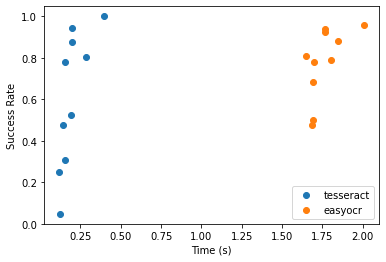

Now that we have test results for each combination, we can compare them and show some nice graphs.

In [ ]:

def printResult(result: list, settings: TestSettings):
    # print test settings
    print(f'Test settings: {settings}')
    print(f'Number of memes: {len(result)}')

    # calculate average time and success rate
    avgTime = sum([test.time for test in result]) / len(result)
    avgSuccess = sum([test.success for test in result]) / len(result)

    print(f'Average time: {avgTime}')
    print(f'Average success rate: {avgSuccess}')

    # calculate median time and success rate
    sortedTime = sorted([test.time for test in result])
    sortedSuccess = sorted([test.success for test in result])

    medianTime = sortedTime[len(sortedTime) // 2]
    medianSuccess = sortedSuccess[len(sortedSuccess) // 2]

    print(f'Median time: {medianTime}')
    print(f'Median success rate: {medianSuccess}')

    # render results in graph
    # time for each meme
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(result)), [test.time for test in result])
    plt.title('Time for each meme')
    plt.xlabel('Meme')
    plt.ylabel('Time (s)')
    plt.show()

    # success rate for each meme
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(result)), [test.success for test in result])
    plt.title('Success rate for each meme')
    plt.xlabel('Meme')
    plt.ylabel('Success rate')
    plt.show()